Team Details:

Pranav Salunkhe - 211IT059

Sanket Babar - 211IT015

Garvit goyal - 211IT021

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools

# Parameters
BATCH_SIZE = 8
NUM_EPOCHS = 8
SUBSET_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='/content/drive/MyDrive/CV_Project/latest_dataset', train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(dataset), SUBSET_SIZE, replace=False)
subset_data = Subset(dataset, subset_indices)
train_loader = DataLoader(subset_data, batch_size=BATCH_SIZE, shuffle=True)

# Define hyperparameter search space
kernel_sizes = [3, 5]
strides = [1, 2]
paddings = [0, 1]
pooling_sizes = [2, 3]
pooling_strides = [1, 2]
pooling_types = ['max', 'avg']

# Squeeze-and-Excitation Attention Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = self.global_avg_pool(x)
        scale = F.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Helper function to create pooling layers
def create_pooling_layer(pool_type, kernel_size, stride):
    if pool_type == 'max':
        return nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
    elif pool_type == 'avg':
        return nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

# Dynamic CNN Model with SE Attention
class DynamicCNN(nn.Module):
    def __init__(self, conv_params, pool_params):
        super(DynamicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=conv_params['kernel_size'],
                               stride=conv_params['stride'], padding=conv_params['padding']).to(DEVICE)
        self.se1 = SEBlock(16).to(DEVICE)  # First SE attention block
        self.pool1 = create_pooling_layer(pool_params['type'], pool_params['size'], pool_params['stride']).to(DEVICE)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1).to(DEVICE)
        self.se2 = SEBlock(32).to(DEVICE)  # Second SE attention block
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(DEVICE)

        self.fc1 = nn.Linear(self._get_flattened_size(), 128).to(DEVICE)
        self.fc2 = nn.Linear(128, 10).to(DEVICE)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32).to(DEVICE)
            x = self.pool1(self.se1(F.relu(self.conv1(x))))
            x = self.pool2(self.se2(F.relu(self.conv2(x))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool1(self.se1(F.relu(self.conv1(x))))
        x = self.pool2(self.se2(F.relu(self.conv2(x))))
        x = x.view(-1, self._get_flattened_size())
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to evaluate a configuration
def evaluate_configuration(conv_params, pool_params):
    model = DynamicCNN(conv_params, pool_params).to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)  # Ensure data is on the same device
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / SUBSET_SIZE
    return accuracy

# Random Search over hyperparameters
def random_search(num_trials=50):
    best_accuracy = 0
    best_params = None

    for _ in range(num_trials):
        conv_params = {
            'kernel_size': random.choice(kernel_sizes),
            'stride': random.choice(strides),
            'padding': random.choice(paddings)
        }
        pool_params = {
            'size': random.choice(pooling_sizes),
            'stride': random.choice(pooling_strides),
            'type': random.choice(pooling_types)
        }

        accuracy = evaluate_configuration(conv_params, pool_params)
        print(f"Params: {conv_params} | {pool_params} -> Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (conv_params, pool_params)

    return best_params, best_accuracy

# Brute-force search over parameter combinations
best_accuracy = 0
best_params = None

for conv_kernel, conv_stride, conv_padding, pool_size, pool_stride, pool_type in itertools.product(
    kernel_sizes, strides, paddings, pooling_sizes, pooling_strides, pooling_types):

    conv_params = {'kernel_size': conv_kernel, 'stride': conv_stride, 'padding': conv_padding}
    pool_params = {'size': pool_size, 'stride': pool_stride, 'type': pool_type}

    accuracy = evaluate_configuration(conv_params, pool_params)
    print(f"Params: {conv_params} | {pool_params} -> Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (conv_params, pool_params)

print(f"\nBest Configuration: {best_params} with Accuracy: {best_accuracy:.4f}")


# Execute random search
best_params, best_accuracy = random_search(num_trials=10)
print(f"\nBest Configuration: {best_params} with Accuracy: {best_accuracy:.4f}")


Files already downloaded and verified
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'max'} -> Accuracy: 0.7800
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.7900
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'max'} -> Accuracy: 0.6200
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.6000
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'max'} -> Accuracy: 0.8300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.8000
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'max'} -> Accuracy: 0.5500
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.5600
Params: {'kernel_size': 3, 'stride

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Parameters
BATCH_SIZE = 8
NUM_EPOCHS = 8
SUBSET_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='/content/drive/MyDrive/CV_Project/latest_dataset', train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(dataset), SUBSET_SIZE, replace=False)
subset_data = Subset(dataset, subset_indices)
train_loader = DataLoader(subset_data, batch_size=BATCH_SIZE, shuffle=True)

# Define hyperparameter search space
kernel_sizes = [3, 5]
strides = [1, 2]
paddings = [0, 1]
pooling_sizes = [2, 3]
pooling_strides = [1, 2]
pooling_types = ['max', 'avg']

# Squeeze-and-Excitation Attention Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)

    def forward(self, x):
        scale = self.global_avg_pool(x)
        scale = F.relu(self.fc1(scale))
        scale = torch.sigmoid(self.fc2(scale))
        return x * scale

# Helper function to create pooling layers
def create_pooling_layer(pool_type, kernel_size, stride):
    if pool_type == 'max':
        return nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
    elif pool_type == 'avg':
        return nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

# Dynamic CNN Model with SE Attention
class DynamicCNN(nn.Module):
    def __init__(self, conv_params, pool_params):
        super(DynamicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=conv_params['kernel_size'],
                               stride=conv_params['stride'], padding=conv_params['padding']).to(DEVICE)
        self.se1 = SEBlock(16).to(DEVICE)  # First SE attention block
        self.pool1 = create_pooling_layer(pool_params['type'], pool_params['size'], pool_params['stride']).to(DEVICE)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1).to(DEVICE)
        self.se2 = SEBlock(32).to(DEVICE)  # Second SE attention block
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2).to(DEVICE)

        self.fc1 = nn.Linear(self._get_flattened_size(), 128).to(DEVICE)
        self.fc2 = nn.Linear(128, 10).to(DEVICE)

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32).to(DEVICE)
            x = self.pool1(self.se1(F.relu(self.conv1(x))))
            x = self.pool2(self.se2(F.relu(self.conv2(x))))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool1(self.se1(F.relu(self.conv1(x))))
        x = self.pool2(self.se2(F.relu(self.conv2(x))))
        x = x.view(-1, self._get_flattened_size())
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to evaluate a configuration
def evaluate_configuration(conv_params, pool_params):
    model = DynamicCNN(conv_params, pool_params).to(DEVICE)
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

    accuracy = correct / SUBSET_SIZE
    return accuracy

# Brute-force search over parameter combinations
best_accuracy = 0
best_params = None

for conv_kernel, conv_stride, conv_padding, pool_size, pool_stride, pool_type in itertools.product(
    kernel_sizes, strides, paddings, pooling_sizes, pooling_strides, pooling_types):

    conv_params = {'kernel_size': conv_kernel, 'stride': conv_stride, 'padding': conv_padding}
    pool_params = {'size': pool_size, 'stride': pool_stride, 'type': pool_type}

    accuracy = evaluate_configuration(conv_params, pool_params)
    print(f"Params: {conv_params} | {pool_params} -> Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (conv_params, pool_params)

print(f"\nBest Configuration: {best_params} with Accuracy: {best_accuracy:.4f}")


Files already downloaded and verified
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'max'} -> Accuracy: 0.9200
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.8700
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'max'} -> Accuracy: 0.6200
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.5500
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'max'} -> Accuracy: 0.8900
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.8300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'max'} -> Accuracy: 0.6800
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.6200
Params: {'kernel_size': 3, 'stride

In [ ]:
best_params

({'kernel_size': 3, 'stride': 1, 'padding': 0},
 {'size': 2, 'stride': 1, 'type': 'avg'})

Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'max'} -> Accuracy: 0.9400
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.9800
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'max'} -> Accuracy: 0.6300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.7400
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'max'} -> Accuracy: 0.9000
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.9300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'max'} -> Accuracy: 0.7100
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.7000
Params: {'kernel_size': 3, 'stride': 1, 'padding': 1} | {'size': 2, 'str

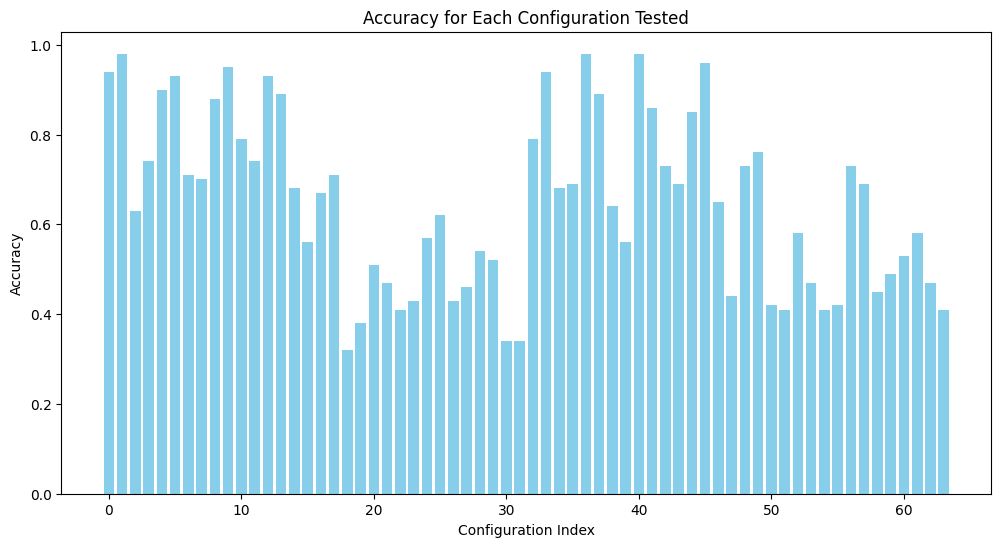

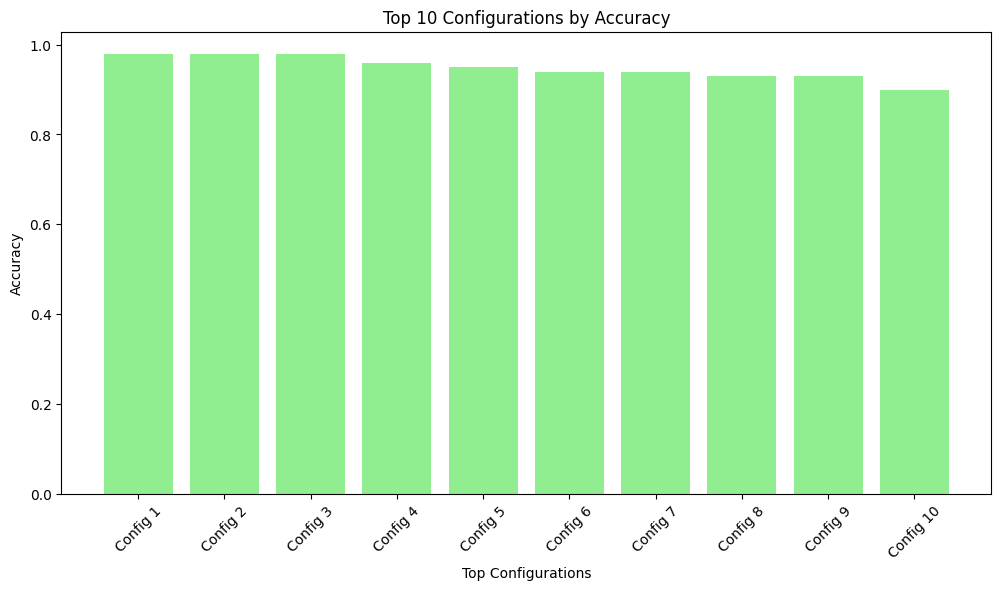

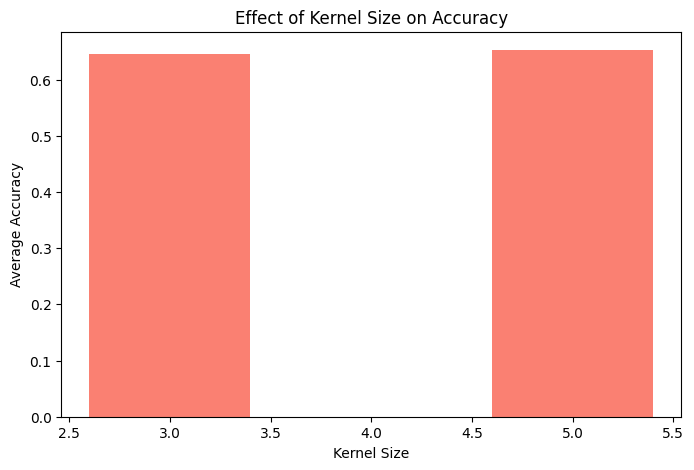

In [ ]:
import matplotlib.pyplot as plt

# Lists to store each configuration's parameters and their corresponding accuracy
results = []
accuracies = []

# Brute-force search over parameter combinations and store results
best_accuracy = 0
best_params = None

for conv_kernel, conv_stride, conv_padding, pool_size, pool_stride, pool_type in itertools.product(
    kernel_sizes, strides, paddings, pooling_sizes, pooling_strides, pooling_types):

    conv_params = {'kernel_size': conv_kernel, 'stride': conv_stride, 'padding': conv_padding}
    pool_params = {'size': pool_size, 'stride': pool_stride, 'type': pool_type}

    accuracy = evaluate_configuration(conv_params, pool_params)
    print(f"Params: {conv_params} | {pool_params} -> Accuracy: {accuracy:.4f}")

    # Save configuration and accuracy
    results.append((conv_params, pool_params))
    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (conv_params, pool_params)

print(f"\nBest Configuration: {best_params} with Accuracy: {best_accuracy:.4f}")

# Plotting Accuracy for Each Configuration
plt.figure(figsize=(12, 6))
plt.bar(range(len(accuracies)), accuracies, color='skyblue')
plt.xlabel("Configuration Index")
plt.ylabel("Accuracy")
plt.title("Accuracy for Each Configuration Tested")
plt.show()

# Plot Top N Configurations Sorted by Accuracy
top_n = 10
sorted_indices = sorted(range(len(accuracies)), key=lambda i: accuracies[i], reverse=True)[:top_n]
top_accuracies = [accuracies[i] for i in sorted_indices]
top_configs = [results[i] for i in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(range(top_n), top_accuracies, color='lightgreen')
plt.xticks(range(top_n), [f"Config {i+1}" for i in range(top_n)], rotation=45)
plt.xlabel("Top Configurations")
plt.ylabel("Accuracy")
plt.title(f"Top {top_n} Configurations by Accuracy")
plt.show()

# Effect of Kernel Size on Accuracy
kernel_accuracies = {}
for i, (conv_params, _) in enumerate(results):
    kernel_size = conv_params['kernel_size']
    if kernel_size not in kernel_accuracies:
        kernel_accuracies[kernel_size] = []
    kernel_accuracies[kernel_size].append(accuracies[i])

avg_kernel_accuracies = {k: sum(v) / len(v) for k, v in kernel_accuracies.items()}

plt.figure(figsize=(8, 5))
plt.bar(avg_kernel_accuracies.keys(), avg_kernel_accuracies.values(), color='salmon')
plt.xlabel("Kernel Size")
plt.ylabel("Average Accuracy")
plt.title("Effect of Kernel Size on Accuracy")
plt.show()

# Similarly, you could plot the effect of other parameters like stride, padding, pooling size, etc.


Files already downloaded and verified


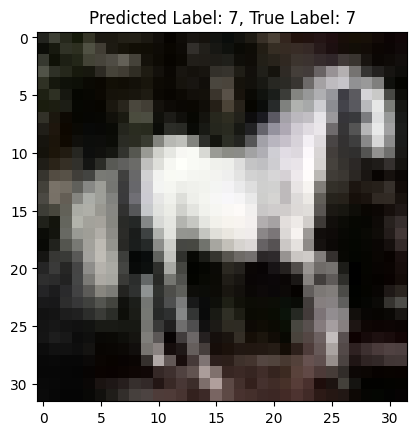

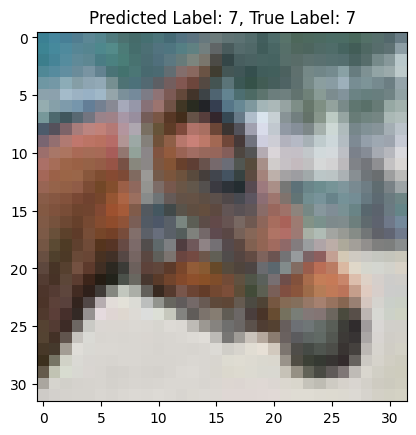

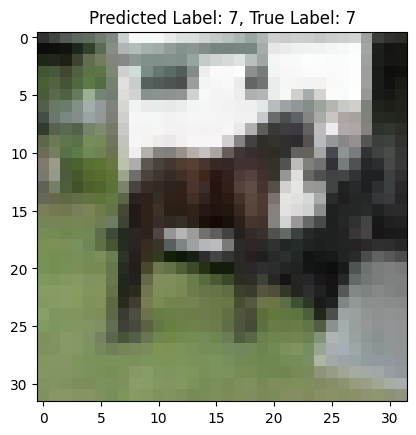

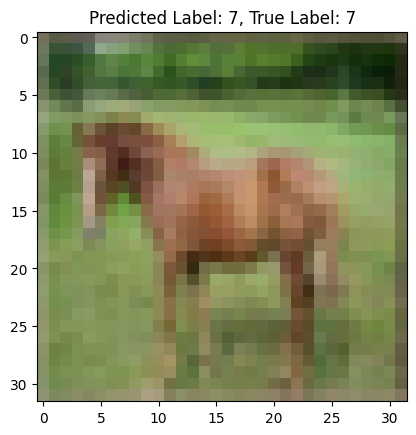

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms


model = DynamicCNN(*best_params)
model.eval()

test_data = datasets.CIFAR10(root='/content/drive/MyDrive/CV_Project/latest_dataset/', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

correct_count = 0
target_correct_images = 4


for i, (image, label) in enumerate(test_loader):
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()
    true_label = label.item()

    # Display image and prediction if correctly predicted
    if predicted == true_label:
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Predicted Label: {predicted}, True Label: {label.item()}")
        plt.show()


        correct_count += 1

        if correct_count >= target_correct_images:
            break


Files already downloaded and verified


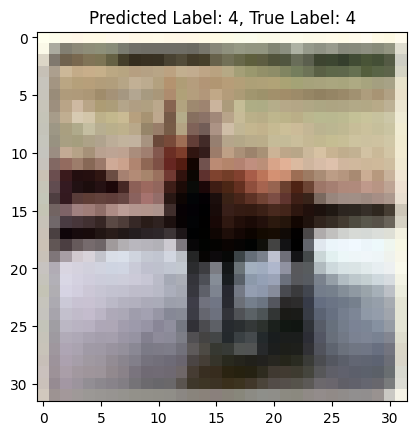

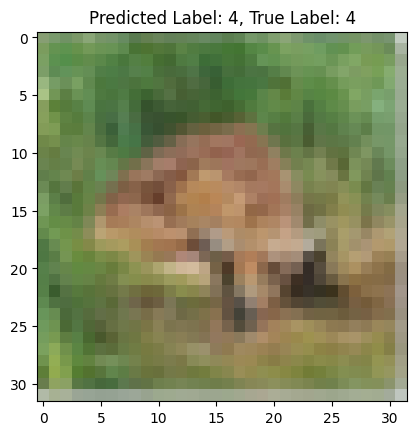

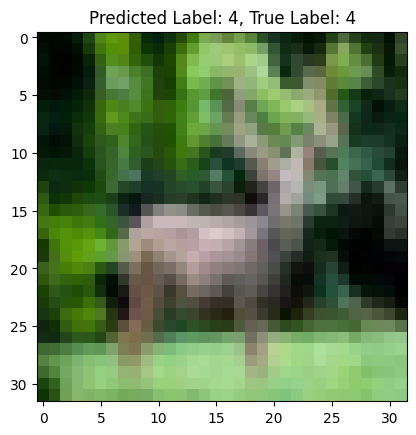

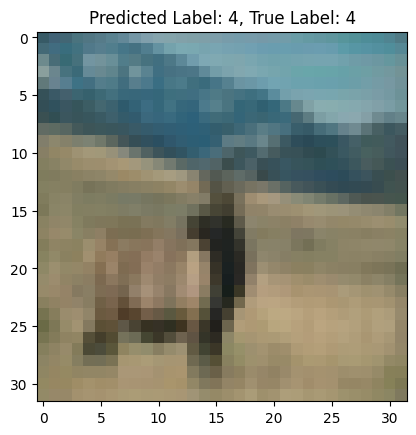

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import random


model = DynamicCNN(*best_params)
model.eval()


test_data = datasets.CIFAR10(root='/content/drive/MyDrive/CV_Project/latest_dataset/', train=False, download=True, transform=transform)


num_samples = 100
random_indices = random.sample(range(len(test_data)), num_samples)
random_subset = Subset(test_data, random_indices)
test_loader = DataLoader(random_subset, batch_size=1, shuffle=False)


correct_count = 0
target_correct_images = 4


for i, (image, label) in enumerate(test_loader):
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted = predicted.item()
    true_label = label.item()


    if predicted == true_label:
        plt.imshow(image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5)
        plt.title(f"Predicted Label: {predicted}, True Label: {label.item()}")
        plt.show()


        correct_count += 1

        if correct_count >= target_correct_images:
            break

